# Transfer learning and fine tuning for image classification

## Transfer learning

### Importing the libraries

In [2]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
tf.__version__

'2.9.2'

### Loading the images

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
path = '/content/drive/MyDrive/Computer Vision/Computer Vision Masterclass/Datasets/homer_bart_2.zip'
zib_object = zipfile.ZipFile(file = path, mode = 'r')
zib_object.extractall('./')
zib_object.close()

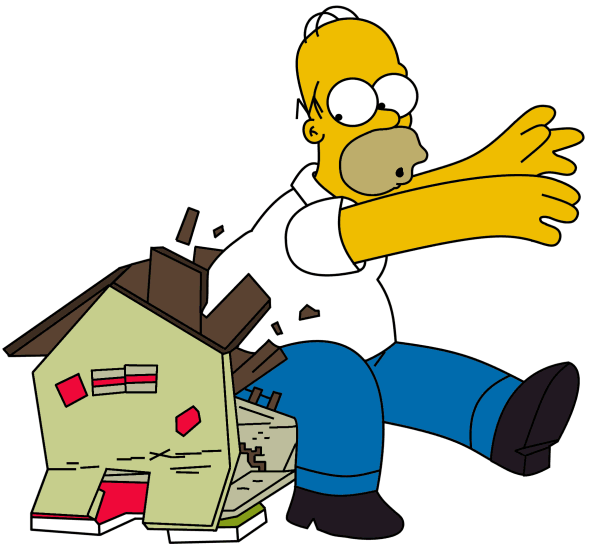

In [8]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/homer/homer123.bmp')

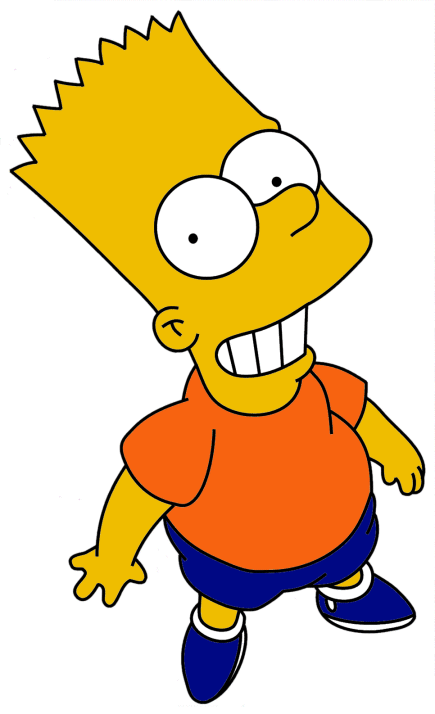

In [9]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart115.bmp')

### Train and test set

In [10]:
training_generator = ImageDataGenerator(rescale = 1./255,
                                        rotation_range = 7,
                                        horizontal_flip = True,
                                        zoom_range = 0.2)

train_dataset = training_generator.flow_from_directory('/content/homer_bart_2/training_set',
                                                       target_size = (256, 256),
                                                       batch_size = 8,
                                                       shuffle = True,
                                                       class_mode = 'categorical')

Found 215 images belonging to 2 classes.


In [11]:
test_generator = ImageDataGenerator(rescale = 1.255)
test_dataset = test_generator.flow_from_directory('/content/homer_bart_2/test_set',
                                                  target_size = (256, 256),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 54 images belonging to 2 classes.


In [12]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [13]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

### Pre-trained network

- ResNet: https://arxiv.org/pdf/1512.03385.pdf
- Documentation: https://keras.io/api/applications/

In [14]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 3s 0us/step


In [15]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [16]:
len(base_model.layers)

175

In [17]:
for layer in base_model.layers:
  layer.trainable = False

In [21]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff2862203d0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ff289042090> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff2869e0650> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff286232890> False
<keras.layers.core.activation.Activation object at 0x7ff287b2be10> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ff286a05110> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff28624dad0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff286a22f10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff2869decd0> False
<keras.layers.core.activation.Activation object at 0x7ff2869df6d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff28640f650> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff28641c250> False
<keras.layers.c

### Custom dense layer

In [22]:
base_model.output

<KerasTensor: shape=(None, 8, 8, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [23]:
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [25]:
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(units = 1025, activation = 'relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(units = 1025, activation = 'relu')(head_model)
head_model = Dropout(rate = 0.2)(head_model)
head_model = Dense(2, activation = 'sigmoid')(head_model)

### Building and training the neural network

In [26]:
base_model.input

<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_1')>

In [27]:
network = Model(inputs = base_model.input, outputs = head_model)

In [28]:
network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [30]:
network.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [31]:
history = network.fit(train_dataset, epochs = 50)

Epoch 1/50
27/27 [==============================] - 14s 142ms/step - loss: 1.0171 - accuracy: 0.5349
Epoch 2/50
27/27 [==============================] - 4s 133ms/step - loss: 0.7170 - accuracy: 0.6465
Epoch 3/50
27/27 [==============================] - 4s 133ms/step - loss: 0.6635 - accuracy: 0.6140
Epoch 4/50
27/27 [==============================] - 4s 132ms/step - loss: 0.7319 - accuracy: 0.5860
Epoch 5/50
27/27 [==============================] - 4s 133ms/step - loss: 0.6679 - accuracy: 0.6093
Epoch 6/50
27/27 [==============================] - 4s 130ms/step - loss: 0.6514 - accuracy: 0.6326
Epoch 7/50
27/27 [==============================] - 6s 223ms/step - loss: 0.6162 - accuracy: 0.6465
Epoch 8/50
27/27 [==============================] - 4s 132ms/step - loss: 0.6436 - accuracy: 0.6140
Epoch 9/50
27/27 [==============================] - 4s 133ms/step - loss: 0.5798 - accuracy: 0.7070
Epoch 10/50
27/27 [==============================] - 4s 133ms/step - loss: 0.5888 - accuracy: 0.702

### Evaluating the neural network

In [32]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [34]:
predictions = network.predict(test_dataset)
predictions

54/54 [==============================] - 1s 14ms/step


array([[3.6937133e-09, 1.0000000e+00],
       [3.3468158e-08, 1.0000000e+00],
       [2.9026249e-03, 9.9923909e-01],
       [1.1722266e-05, 9.9999785e-01],
       [2.2706734e-05, 9.9999452e-01],
       [9.8618839e-05, 9.9998236e-01],
       [2.7978193e-02, 9.8966563e-01],
       [3.9760917e-07, 1.0000000e+00],
       [1.1694202e-06, 9.9999988e-01],
       [5.8305147e-04, 9.9983060e-01],
       [1.9187635e-07, 1.0000000e+00],
       [6.7043807e-08, 1.0000000e+00],
       [3.6477050e-04, 9.9990356e-01],
       [1.9456260e-02, 9.8950738e-01],
       [3.7800866e-05, 9.9999392e-01],
       [7.0110089e-03, 9.9710637e-01],
       [2.2860549e-03, 9.9926537e-01],
       [4.7702410e-06, 9.9999905e-01],
       [9.9833719e-03, 9.9472767e-01],
       [2.9238030e-05, 9.9999535e-01],
       [3.1618252e-03, 9.9891651e-01],
       [4.7971707e-07, 1.0000000e+00],
       [1.1398538e-02, 9.9416333e-01],
       [7.0310527e-01, 3.3949357e-01],
       [3.1095569e-04, 9.9986696e-01],
       [4.2797765e-05, 9.

In [35]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.5

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
cm

array([[ 1, 27],
       [ 0, 26]])

In [39]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       1.00      0.04      0.07        28
           1       0.49      1.00      0.66        26

    accuracy                           0.50        54
   macro avg       0.75      0.52      0.36        54
weighted avg       0.75      0.50      0.35        54



## Fine tuning

### Implementing

In [40]:
base_model.trainable = True

In [45]:
for layer in base_model.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff2862203d0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ff289042090> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff2869e0650> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff286232890> False
<keras.layers.core.activation.Activation object at 0x7ff287b2be10> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ff286a05110> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff28624dad0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff286a22f10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff2869decd0> False
<keras.layers.core.activation.Activation object at 0x7ff2869df6d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff28640f650> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff28641c250> False
<keras.layers.c

In [42]:
len(base_model.layers)

175

In [44]:
fine_tuning_at = 140
for layer in base_model.layers[:fine_tuning_at]:
  layer.trainable = False

In [46]:
network.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [47]:
history = network.fit(train_dataset, epochs = 50)

Epoch 1/50
27/27 [==============================] - 9s 151ms/step - loss: 2.7077 - accuracy: 0.5628
Epoch 2/50
27/27 [==============================] - 4s 159ms/step - loss: 0.7810 - accuracy: 0.5814
Epoch 3/50
27/27 [==============================] - 7s 254ms/step - loss: 0.6535 - accuracy: 0.6465
Epoch 4/50
27/27 [==============================] - 4s 159ms/step - loss: 0.6357 - accuracy: 0.6930
Epoch 5/50
27/27 [==============================] - 4s 144ms/step - loss: 0.5799 - accuracy: 0.7070
Epoch 6/50
27/27 [==============================] - 5s 184ms/step - loss: 0.6133 - accuracy: 0.7116
Epoch 7/50
27/27 [==============================] - 6s 207ms/step - loss: 0.4545 - accuracy: 0.7907
Epoch 8/50
27/27 [==============================] - 7s 277ms/step - loss: 0.4157 - accuracy: 0.7767
Epoch 9/50
27/27 [==============================] - 5s 196ms/step - loss: 0.3194 - accuracy: 0.8698
Epoch 10/50
27/27 [==============================] - 5s 188ms/step - loss: 0.4346 - accuracy: 0.8140

### Evaluate 

In [48]:
predictions = network.predict(test_dataset)
predictions

54/54 [==============================] - 2s 14ms/step


array([[1.70013448e-06, 9.99987960e-01],
       [2.40611751e-02, 9.46852684e-01],
       [2.51751617e-02, 9.53177392e-01],
       [1.05718664e-06, 9.99991417e-01],
       [2.54136510e-04, 9.99029040e-01],
       [3.39722729e-11, 1.00000000e+00],
       [1.19539625e-04, 9.99612987e-01],
       [2.23713287e-04, 9.99308467e-01],
       [4.48286155e-05, 9.99884129e-01],
       [2.23814204e-04, 9.99270260e-01],
       [1.59436383e-03, 9.94771302e-01],
       [3.50905437e-04, 9.98578906e-01],
       [3.67193046e-04, 9.98673916e-01],
       [5.56749598e-08, 9.99999523e-01],
       [1.42851425e-02, 9.74656940e-01],
       [1.92291782e-06, 9.99988198e-01],
       [9.71932046e-09, 9.99999881e-01],
       [1.09185509e-01, 8.13916206e-01],
       [2.72996146e-02, 9.45033431e-01],
       [1.02596177e-05, 9.99961972e-01],
       [4.11907182e-04, 9.98260438e-01],
       [2.15588352e-05, 9.99890089e-01],
       [4.43972640e-05, 9.99821007e-01],
       [2.43607089e-02, 9.58482683e-01],
       [3.860833

In [49]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [50]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

## Saving and loading the model

In [51]:
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [52]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

In [53]:
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer

In [54]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [55]:
network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Classifying one single image

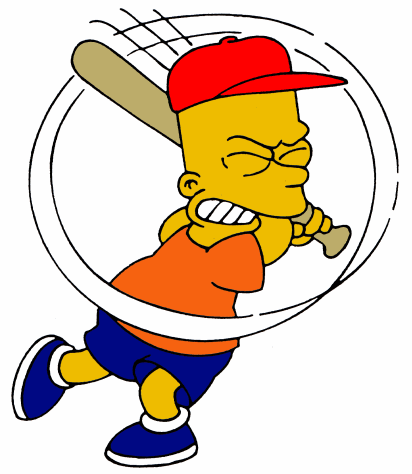

In [56]:
image = cv2.imread('/content/homer_bart_2/test_set/bart/bart15.bmp')
cv2_imshow(image)

In [57]:
image.shape

(474, 412, 3)

In [59]:
image = cv2.resize(image, (256, 256))
image.shape

(256, 256, 3)

In [62]:
image = image / 255
image

array([[[[0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],

        [[0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],

        [[0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],

        ...,

        [[0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]

In [63]:
image = image.reshape(-1, 256, 256, 3)
image.shape

(1, 256, 256, 3)

In [64]:
result = network_loaded.predict(image)
result

1/1 [==============================] - 1s 1s/step


array([[0.67142576, 0.3583298 ]], dtype=float32)

In [66]:
result = np.argmax(result)
result

0

In [67]:
if result == 0:
  print('Bart')
else:
  print('Homer')

Bart
